## Import

In [1]:
import os
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def calc_stats(basepath, safe = True):
    safe_stats = {}
    meanlogscores_stats = {}
    list_df = []
    list_flat_logscores = []
    all_logscores = []
    dict_prop_bef, dict_prop_aft = {}, {}
    bef_timesteps_tuple = [(-25, -20), (-20, -15), (-15, -10), (-10, -5), (-5, 0)]
    for timestep_tuple in bef_timesteps_tuple:
        dict_prop_bef[timestep_tuple] = []
    aft_timesteps_tuple = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25)]
    for timestep_tuple in aft_timesteps_tuple:
        dict_prop_aft[timestep_tuple] = []
    
    if safe:
        for i in range(0, 26):
            safe_stats[i] = []
            meanlogscores_stats[i] = []
        csv_path = os.path.join(basepath, 'enriched_trajs', 'safe')
    else:
        for i in range(0, 1000):
            safe_stats[i] = []
            if i > 25:
                meanlogscores_stats[i] = []
        csv_path = os.path.join(basepath, 'enriched_trajs', 'unsafe')
            
    csv_files = [f for f in os.listdir(csv_path) if os.path.isfile(os.path.join(csv_path, f))]

    for i, filename in enumerate(csv_files):
        if i % 1000 == 0:
            print("Processing file", i, "out of", len(csv_files), "files")
        df = pd.read_csv(os.path.join(csv_path, filename))
        total_logscores = df['new_logscore_mean'].sum()
        meanlogscores_stats[df['c'].sum().astype(int)].append(total_logscores)
        filtered_df = df[df.c > 0][['c', 'cum_c', 'new_logscore_mean']]
        filtered_idx = [0] + filtered_df.index.tolist()
        filtered_cum_c = [0] + filtered_df.cum_c.astype(int).tolist()

        for j in range(len(filtered_idx)):
            if j < len(filtered_idx) - 1:
                safe_stats[filtered_cum_c[j]].append(df[filtered_idx[j]:filtered_idx[j+1]]['new_logscore_mean'].sum() / total_logscores)
                len_flat_region = filtered_idx[j+1] - filtered_idx[j]
                #buffer_space = math.ceil(len_flat_region * 0.2)
                buffer_space = 20
                if len_flat_region >= 100:
                    list_flat_logscores.append(df[(filtered_idx[j]+buffer_space):(filtered_idx[j+1]-buffer_space)]['new_logscore_mean'].mean())
            else:                
                safe_stats[filtered_cum_c[j]].append(df[filtered_idx[j]:]['new_logscore_mean'].sum() / total_logscores)
                len_flat_region = df.shape[0] - filtered_idx[j]
                #buffer_space = math.ceil(len_flat_region * 0.2)
                buffer_space = 20
                if len_flat_region >= 100:
                    list_flat_logscores.append(df[(filtered_idx[j]+buffer_space):]['new_logscore_mean'].mean())
            
        if df['new_logscore_mean'].sum() <= 0 and not safe:
            threshold_idx = df[(df['cum_c'] == 26) & (df['c'] == 1)].index[0]
            for timestep_bef_tuple in bef_timesteps_tuple:
                start_idx, end_idx = threshold_idx + timestep_bef_tuple[0], threshold_idx + timestep_bef_tuple[1]
                if start_idx >= 0 or end_idx > 0:
                    if start_idx < 0:
                        start_idx = 0
                    elif end_idx <= 0:
                        end_idx = 1
                        
                    dict_prop_bef[timestep_bef_tuple].append(df[start_idx:end_idx]['new_logscore_mean'].mean() / df['new_logscore_mean'].mean())
                    
            for timestep_aft_tuple in aft_timesteps_tuple:
                start_idx, end_idx = threshold_idx + timestep_aft_tuple[0], threshold_idx + timestep_aft_tuple[1]
                if start_idx < df.shape[0] or end_idx <= df.shape[0]:                    
                    if start_idx >= df.shape[0]:
                        start_idx = df.shape[0] - 1
                    elif end_idx > df.shape[0]:
                        end_idx = df.shape[0]
                    
                    dict_prop_aft[timestep_aft_tuple].append(df[start_idx:end_idx]['new_logscore_mean'].mean() / df['new_logscore_mean'].mean())
                    
        list_df.append(df)
        all_logscores += df['new_logscore_mean'].tolist()
        

    return safe_stats, meanlogscores_stats, list_df, list_flat_logscores, all_logscores, dict_prop_bef, dict_prop_aft#, c0_logscores, c1_logscores
        

## Ant Domain

In [3]:
base_path = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyAntVelocity-v1/SafetyAntVelocity-v1---55fb775100c88b77dcb231fcd49be70fc21188a3f53dc001b075b74c83bb94f1/PPOLagLearnedH-{SafetyAntVelocity-v1}/seed-000-2025-02-06-08-14-43'

safe_stats, safe_meanlogscores, safe_dfs, safe_flat_logscores, safe_all_logscores, _, _ = calc_stats(base_path, safe = True)
unsafe_stats, unsafe_meanlogscores, unsafe_dfs, unsafe_flat_logscores, unsafe_all_logscores, unsafe_dict_prop_bef, unsafe_dict_prop_aft = calc_stats(base_path, safe = False)

Processing file 0 out of 5661 files
Processing file 1000 out of 5661 files
Processing file 2000 out of 5661 files
Processing file 3000 out of 5661 files
Processing file 4000 out of 5661 files
Processing file 5000 out of 5661 files
Processing file 0 out of 4339 files
Processing file 1000 out of 4339 files
Processing file 2000 out of 4339 files
Processing file 3000 out of 4339 files
Processing file 4000 out of 4339 files


In [4]:
print("From Safe Trajs, Mean Logscores of Flat Region:", np.mean(safe_flat_logscores), "Stdev of Flat Region:", np.std(safe_flat_logscores))
print("From Unsafe Trajs, Mean Logscores of Flat Region:", np.mean(unsafe_flat_logscores), "Stdev of Flat Region:", np.std(unsafe_flat_logscores))

From Safe Trajs, Mean Logscores of Flat Region: -0.000257079220451896 Stdev of Flat Region: 0.0005860396111960158
From Unsafe Trajs, Mean Logscores of Flat Region: -0.00043990131033721906 Stdev of Flat Region: 0.0007457685552565808


In [5]:
print("From Safe Trajs, Mean Logscores:", np.mean(safe_all_logscores), "Stdev:", np.std(safe_all_logscores))
print("From Unsafe Trajs, Mean Logscores:", np.mean(unsafe_all_logscores), "Stdev:", np.std(unsafe_all_logscores))

From Safe Trajs, Mean Logscores: -0.00026621082942143893 Stdev: 0.0018153863520662468
From Unsafe Trajs, Mean Logscores: -0.0006320193020989752 Stdev: 0.0028560241282601768


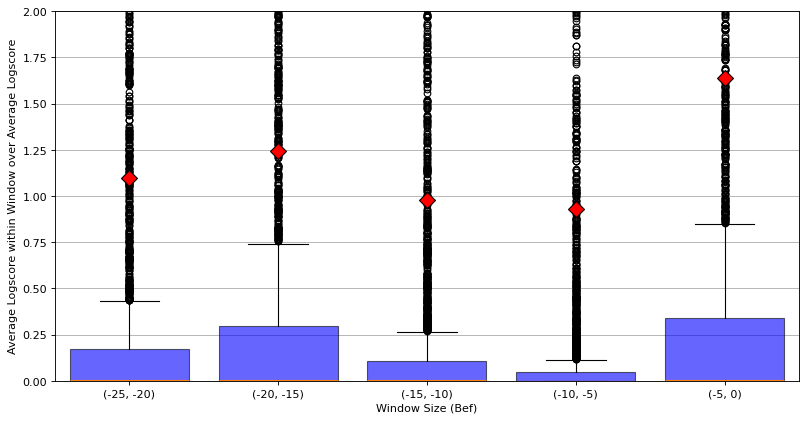

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)

x_labels = list(unsafe_dict_prop_bef.keys())

plot_data = []
for k in list(unsafe_dict_prop_bef.keys()):
    plot_data.append(unsafe_dict_prop_bef[k])

# Customization for the mean marker
meanprops = {
    "marker": "D",           # Diamond shape
    "markerfacecolor": "red", # Red color
    "markeredgecolor": "black",
    "markersize": 10          # Larger size
}

# Create the boxplots
plt.boxplot(plot_data, positions=list(range(len(x_labels))), widths=0.8, patch_artist=True,
            boxprops=dict(facecolor='blue', alpha=0.6), tick_labels=x_labels, showmeans=True, meanprops=meanprops)

plt.ylim(0, 2)

#Customize x-axis positions
#plt.xticks([(pos1 + pos2) / 2 for pos1, pos2 in zip(positions1, positions2)], x_labels)

# Add grid and labels
#plt.title('Multiple Boxplots per Category')
plt.ylabel('Average Logscore within Window over Average Logscore')
plt.xlabel('Window Size (Bef)')
plt.grid(axis='y')

# Show the plot
plt.show()

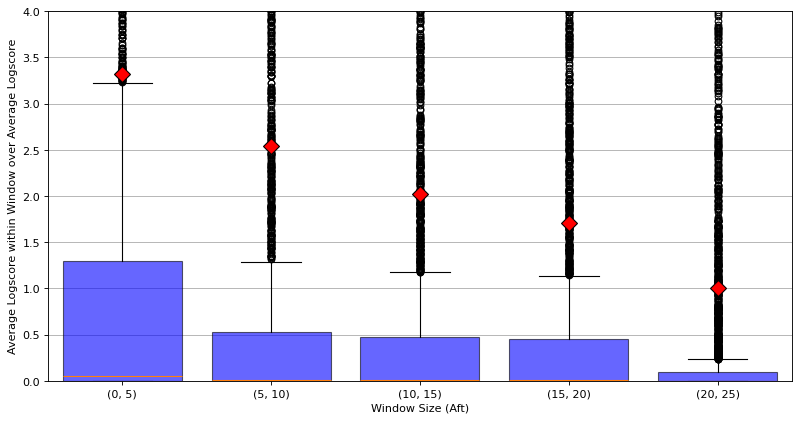

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)

x_labels = list(unsafe_dict_prop_aft.keys())

plot_data = []
for k in list(unsafe_dict_prop_aft.keys()):
    plot_data.append(unsafe_dict_prop_aft[k])

# Customization for the mean marker
meanprops = {
    "marker": "D",           # Diamond shape
    "markerfacecolor": "green", # Red color
    "markeredgecolor": "black",
    "markersize": 10          # Larger size
}

# Create the boxplots
plt.boxplot(plot_data, positions=list(range(len(x_labels))), widths=0.8, patch_artist=True,
            boxprops=dict(facecolor='blue', alpha=0.6), tick_labels=x_labels, showmeans=True, meanprops=meanprops)

plt.ylim(0, 4)

#Customize x-axis positions
#plt.xticks([(pos1 + pos2) / 2 for pos1, pos2 in zip(positions1, positions2)], x_labels)

# Add grid and labels
#plt.title('Multiple Boxplots per Category')
plt.ylabel('Average Logscore within Window over Average Logscore')
plt.xlabel('Window Size (Aft)')
plt.grid(axis='y')

# Show the plot
plt.show()

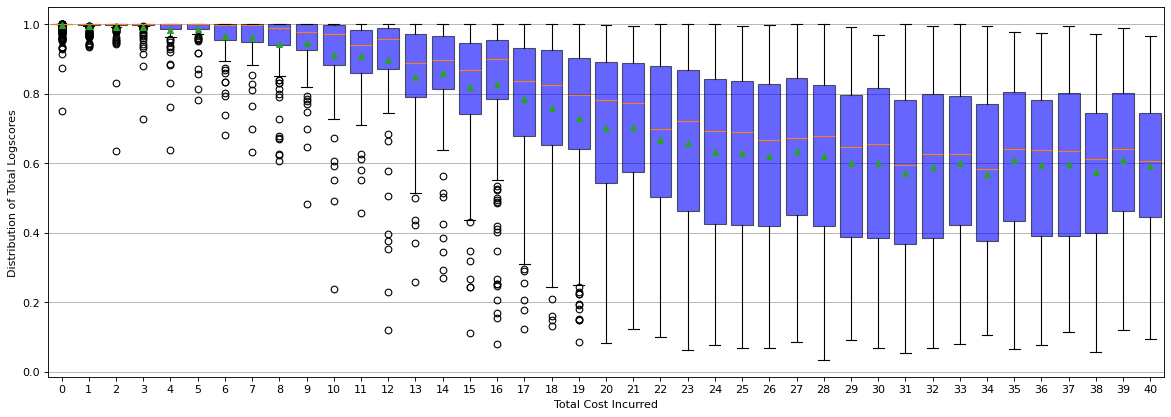

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)

plot_data = []
for i in range(41):
    if i > 25:
        plot_data.append([np.exp(logscore) for logscore in unsafe_meanlogscores[i]])
    else:
        plot_data.append([np.exp(logscore) for logscore in safe_meanlogscores[i]])

# Example data
x_labels = list(range(41))

# Create the boxplots
plt.boxplot(plot_data, positions=x_labels, widths=0.8, patch_artist=True,
            boxprops=dict(facecolor='blue', alpha=0.6), tick_labels=x_labels, showmeans=True)

#Customize x-axis positions
#plt.xticks([(pos1 + pos2) / 2 for pos1, pos2 in zip(positions1, positions2)], x_labels)

# Add grid and labels
#plt.title('Multiple Boxplots per Category')
plt.ylabel('Distribution of Total Logscores')
plt.xlabel('Total Cost Incurred')
plt.grid(axis='y')

# Show the plot
plt.show()

In [48]:
plotDF = unsafe_dfs[2000]
# Example time series data
x = list(range(1000))
y_cum_c = plotDF['cum_c'].to_numpy()
y_c = plotDF['c'].to_numpy()
y_norm_logscores = plotDF['new_logscore_mean'].to_numpy() / plotDF['new_logscore_mean'].min()

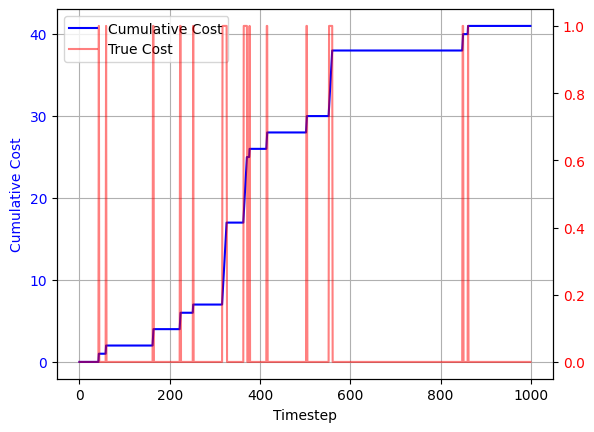

In [49]:
# Create the plot
fig, ax1 = plt.subplots()

# Plot the first time series
line1, = ax1.plot(x, y_cum_c, color='blue', label='Cumulative Cost')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Cumulative Cost', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis
ax2 = ax1.twinx()
line2, = ax2.plot(x, y_c, color='red', label='True Cost', alpha = 0.5)
#ax2.plot(x, y_norm_logscores, color='orange', label='Normalized Logscores', alpha = 0.5)
ax2.set_ylabel('True Cost', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title
#fig.suptitle('Two Time Series with Different Scales')

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Show the plot
plt.show()

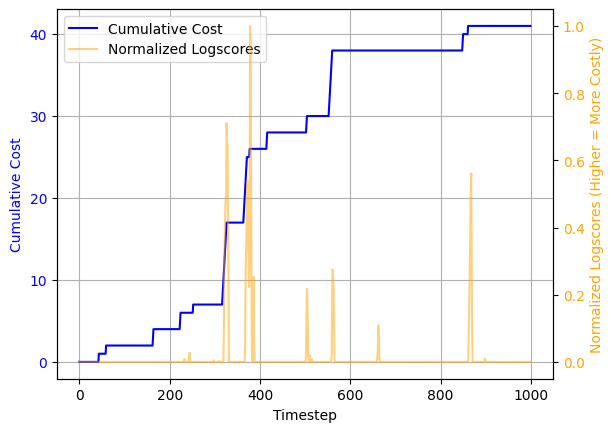

In [53]:
# Create the plot
fig, ax1 = plt.subplots()

# Plot the first time series
line1, = ax1.plot(x, y_cum_c, color='blue', label='Cumulative Cost')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Cumulative Cost', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis
ax2 = ax1.twinx()
line2, = ax2.plot(x, y_norm_logscores, color='orange', label='Normalized Logscores', alpha = 0.5)
#ax2.plot(x, y_norm_logscores, color='orange', label='Normalized Logscores', alpha = 0.5)
ax2.set_ylabel('Normalized Logscores (Higher = More Costly)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title
#fig.suptitle('Two Time Series with Different Scales')

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Show the plot
plt.show()

In [54]:
for i in range(0, 26):
    print("Accumulated Cost:", i, ", Length:", len(safe_stats[i]), ", Mean Contribution (Prop):", np.mean(safe_stats[i]))

Accumulated Cost: 0 , Length: 5661 , Mean Contribution (Prop): 0.18230344548842872
Accumulated Cost: 1 , Length: 4721 , Mean Contribution (Prop): 0.04542332070382753
Accumulated Cost: 2 , Length: 4544 , Mean Contribution (Prop): 0.04284532300961135
Accumulated Cost: 3 , Length: 4401 , Mean Contribution (Prop): 0.04025137243139074
Accumulated Cost: 4 , Length: 4296 , Mean Contribution (Prop): 0.045336129679332225
Accumulated Cost: 5 , Length: 4193 , Mean Contribution (Prop): 0.05042728043111586
Accumulated Cost: 6 , Length: 4085 , Mean Contribution (Prop): 0.05029444027036562
Accumulated Cost: 7 , Length: 4007 , Mean Contribution (Prop): 0.05219610674751973
Accumulated Cost: 8 , Length: 3918 , Mean Contribution (Prop): 0.060849817696773174
Accumulated Cost: 9 , Length: 3826 , Mean Contribution (Prop): 0.05842559953642981
Accumulated Cost: 10 , Length: 3733 , Mean Contribution (Prop): 0.06339221589704298
Accumulated Cost: 11 , Length: 3643 , Mean Contribution (Prop): 0.06936240845454487


In [55]:
for i in range(0, 1000):
    if len(unsafe_stats[i]) > 0:
        print("Accumulated Cost:", i, ", Length:", len(unsafe_stats[i]), ", Mean Contribution (Prop):", np.mean(unsafe_stats[i]))

Accumulated Cost: 0 , Length: 4339 , Mean Contribution (Prop): 0.0007258892100589166
Accumulated Cost: 1 , Length: 4339 , Mean Contribution (Prop): 0.0016729095516658193
Accumulated Cost: 2 , Length: 4339 , Mean Contribution (Prop): 0.0023324244853874963
Accumulated Cost: 3 , Length: 4339 , Mean Contribution (Prop): 0.0037654337839119673
Accumulated Cost: 4 , Length: 4339 , Mean Contribution (Prop): 0.005825831307598716
Accumulated Cost: 5 , Length: 4339 , Mean Contribution (Prop): 0.007480979758342008
Accumulated Cost: 6 , Length: 4339 , Mean Contribution (Prop): 0.01020398324063953
Accumulated Cost: 7 , Length: 4339 , Mean Contribution (Prop): 0.013192597867258357
Accumulated Cost: 8 , Length: 4339 , Mean Contribution (Prop): 0.015608250909390524
Accumulated Cost: 9 , Length: 4339 , Mean Contribution (Prop): 0.016984535303720943
Accumulated Cost: 10 , Length: 4339 , Mean Contribution (Prop): 0.0209872617275564
Accumulated Cost: 11 , Length: 4339 , Mean Contribution (Prop): 0.02498237

In [21]:
plotDF = unsafe_dfs[4]

1. Flat region with 100 timesteps, only inner 80%, computer average logscore
2. Near threshold (budget 25), 10 timestep bef & 10 timesteps aft
3. x-axis is timestep aft, y is the percentage of logscore (boxplots)